<a href="https://colab.research.google.com/github/Mounish2023/fastaicourse/blob/main/Training_State_of_the_Art_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.IMAGENETTE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/imagenette2/noisy_imagenette.csv'),Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/val')]

In [5]:
(path/'/root/.fastai/data/imagenette2/train').ls()

(#10) [Path('/root/.fastai/data/imagenette2/train/n03445777'),Path('/root/.fastai/data/imagenette2/train/n03425413'),Path('/root/.fastai/data/imagenette2/train/n03000684'),Path('/root/.fastai/data/imagenette2/train/n03028079'),Path('/root/.fastai/data/imagenette2/train/n03888257'),Path('/root/.fastai/data/imagenette2/train/n02979186'),Path('/root/.fastai/data/imagenette2/train/n03394916'),Path('/root/.fastai/data/imagenette2/train/n03417042'),Path('/root/.fastai/data/imagenette2/train/n01440764'),Path('/root/.fastai/data/imagenette2/train/n02102040')]

In [6]:
(path/'/root/.fastai/data/imagenette2/train/n03417042').ls()

(#961) [Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_3005.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_908.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_4994.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_27085.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_3107.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_7096.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_18246.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_7187.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/ILSVRC2012_val_00036554.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_684.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/ILSVRC2012_val_00047374.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_20609.JPEG'),Path('/root/.fastai/data/imagenette2/train/n03417042/n03417042_15913.JPEG

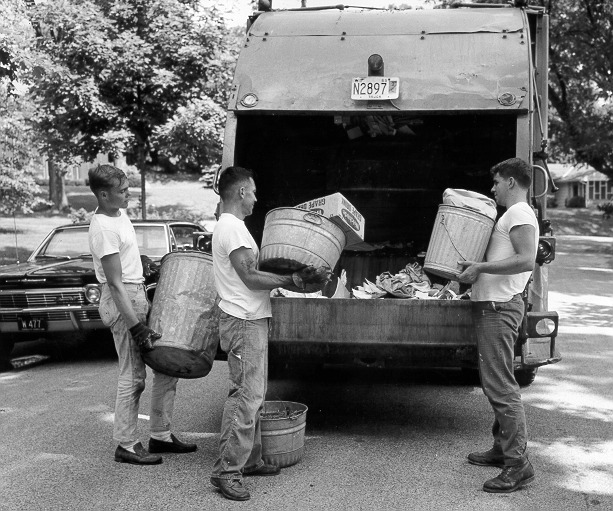

In [7]:
from PIL import Image
Image.open((path/'/root/.fastai/data/imagenette2/train/n03417042/n03417042_2236.JPEG'))

In [8]:
import pandas as pd
df = pd.read_csv(path/'/root/.fastai/data/imagenette2/noisy_imagenette.csv')
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


In [9]:
dblock = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()),
    get_items = get_image_files,
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [10]:
dls = dblock.dataloaders(path/'/root/.fastai/data/imagenette2/train')

In [11]:
len(dls.train), len(dls.valid), dls.bs

(118, 30, 64)

In [12]:
xb,yb = dls.one_batch()

In [13]:
xb.shape,yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [14]:
xb.mean(dim=[0,2,3]), xb.std(dim=[0,2,3])

(TensorImage([0.4651, 0.4558, 0.4313], device='cuda:0'),
 TensorImage([0.2751, 0.2787, 0.2976], device='cuda:0'))

In [15]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(2,3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,1.659197,1.481642,0.529847,01:51
1,1.208634,0.978955,0.686741,01:45


# With Normalization

In [16]:
def get_dls(bs, size):
  dblock = DataBlock(
      blocks = (ImageBlock(), CategoryBlock()),
      get_items = get_image_files,
      get_y = parent_label,
      item_tfms= Resize(460),
      batch_tfms = [*aug_transforms(size=size, min_scale=0.75),
                    Normalize.from_stats(*imagenet_stats)]
  )
  return dblock.dataloaders(path,bs=bs)

dls_with_norm = get_dls(bs=64,size=224)

In [18]:
x,y = dls_with_norm.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.2590, -0.1409, -0.0754], device='cuda:0'),
 TensorImage([1.2660, 1.2561, 1.3171], device='cuda:0'))

In [19]:
learn_norm = Learner(dls_with_norm, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                     )
learn_norm.fit_one_cycle(2,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.221082,1.350860,0.598954,02:32
1,0.834945,0.730541,0.773712,02:31


# Progressive Resizing

In [20]:
dls_ls = get_dls(bs=128,size=128)
learn_ls = Learner(dls_ls,model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn_ls.fit_one_cycle(1,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.855017,0.736172,0.768484,02:01


In [21]:
learn_ls.dls = get_dls(64,224)
learn_ls.fit_one_cycle(1,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.795642,0.621442,0.812920,02:31


# Test Time Augmentation

In [22]:
preds, targs = learn_ls.tta()
accuracy(preds, targs).item()

0.8106796145439148